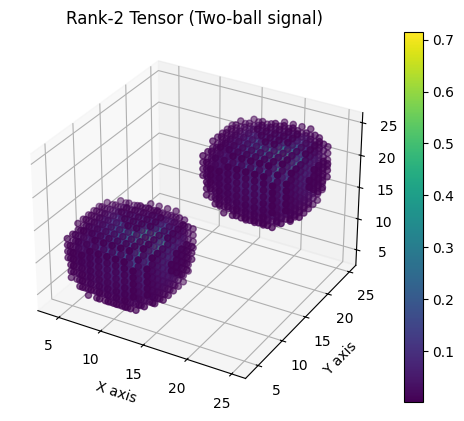

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Assume these are dimensions of the MRI data
dim_x1, dim_x2, dim_x3 = 48, 48, 48

# Define function to create signal tensor
def create_signal_tensor(rank):
    if rank == 1:
        # One-ball signal (rank-1 decomposition)
        B1 = np.zeros((dim_x1, 1))
        B2 = np.zeros((dim_x2, 1))
        B3 = np.zeros((dim_x3, 1))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
        return B1, B2, B3
    elif rank == 2:
        # Two-ball signal (rank-2 decomposition)
        B1 = np.zeros((dim_x1, 2))
        B2 = np.zeros((dim_x2, 2))
        B3 = np.zeros((dim_x3, 2))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            B1[15 + j, 1] = np.sin(j * np.pi / 14)
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        return B1, B2, B3

# Function to pack the rank-1 tensor using np.tensordot
def pack_rank1_tensor(B1, B2, B3):
    return np.tensordot(np.tensordot(B1[:, 0], B2[:, 0], axes=0), B3[:, 0], axes=0)

# Function to pack the rank-2 tensor using np.tensordot
def pack_rank2_tensor(B1, B2, B3):
    tensor = np.zeros((dim_x1, dim_x2, dim_x3))
    for i in range(B1.shape[1]):  # Loop over both components (rank-2 tensor)
        tensor += np.tensordot(np.tensordot(B1[:, i], B2[:, i], axes=0), B3[:, i], axes=0)
    return tensor

# Function to plot 3D tensor using scatter plot
def plot_3d_tensor_scatter(tensor, title="3D Tensor Scatter Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare the grid matching the tensor dimensions
    x, y, z = np.meshgrid(np.arange(tensor.shape[0]),
                          np.arange(tensor.shape[1]),
                          np.arange(tensor.shape[2]),
                          indexing='ij')

    # Smooth the tensor values for visualization
    tensor_smoothed = gaussian_filter(tensor, sigma=1)

    # Flatten the arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values = tensor_smoothed.flatten()

    # Select points where tensor values are significant (above a threshold)
    isovalue = tensor_smoothed.mean()
    mask = values > isovalue
    x_plot = x_flat[mask]
    y_plot = y_flat[mask]
    z_plot = z_flat[mask]
    values_plot = values[mask]

    # Plot the scatter
    scatter = ax.scatter(x_plot, y_plot, z_plot, c=values_plot, cmap='viridis', marker='o')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Add color bar to indicate values
    fig.colorbar(scatter, ax=ax)

    plt.show()

# Example usage:
# Generate and pack the rank-1 tensor (one-ball signal)
B1_rank1, B2_rank1, B3_rank1 = create_signal_tensor(rank=1)
tensor_rank1 = pack_rank1_tensor(B1_rank1, B2_rank1, B3_rank1)

# Generate and pack the rank-2 tensor (two-ball signal)
B1_rank2, B2_rank2, B3_rank2 = create_signal_tensor(rank=2)
tensor_rank2 = pack_rank2_tensor(B1_rank2, B2_rank2, B3_rank2)

# Plot the rank-2 tensor using scatter plot (two-ball signal)
plot_3d_tensor_scatter(tensor_rank2, title="Rank-2 Tensor (Two-ball signal)")


In [27]:
import os
import pandas as pd
import nibabel as nib
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from skimage.measure import block_reduce
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorly as tl

#Debugging import
import importlib
var = 'TensorDecisionTreeRegressorP' #the published version of code
package = importlib.import_module(var)
for name, value in package.__dict__.items():
    if not name.startswith("__"):
        globals()[name] = value

from TensorDecisionTreeRegressorP import *

import os
import nibabel as nib
import numpy as np
import matplotlib as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# File path to the CSV file
csv_file = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/ADNIData.csv'
df = pd.read_csv(csv_file)
# Remove rows where ADAS11_bl is missing (NaN)
df_cleaned = df.dropna(subset=['ADAS11_bl'])

# Extract the 'ADAS11_bl' column as the y variable
y_variable = df_cleaned['ADAS11_bl'].values

# Split the dataframe based on the DX_bl column values
cn_group = df_cleaned[df_cleaned['DX_bl'] == 'CN']
ad_group = df_cleaned[df_cleaned['DX_bl'] == 'AD']
lmci_group = df_cleaned[df_cleaned['DX_bl'] == 'LMCI']

# Display the counts for each group after removing NA
print(f"CN group size: {cn_group.shape[0]}")
print(f"AD group size: {ad_group.shape[0]}")
print(f"LMCI group size: {lmci_group.shape[0]}")

# Directory containing the 3D images
directory = '/Users/zhihaochen/Documents/CommenDesktop/RICE/MyProject/Bayes_Tensor_Tree/3D-images/3D-Images/bl'

# Initialize dictionaries to hold the images and y values for each group
cn_images, ad_images, lmci_images = [], [], []
cn_y, ad_y, lmci_y = [], [], []

# Function to load the images based on PTID matching and append y values
def load_images_and_y(group, image_list, y_list):
    for _, row in group.iterrows():
        ptid = row['PTID']
        # Find the corresponding file based on PTID
        filename = f'{ptid}.nii.gz'
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            # Load the NIfTI file
            img = nib.load(file_path)
            data = img.get_fdata()
            
            # Append the 3D image data and y value to the respective lists
            image_list.append(data)
            y_list.append(row['ADAS11_bl'])
        else:
            print(f"File {filename} not found.")

# Load images and y values for each group
load_images_and_y(cn_group, cn_images, cn_y)
load_images_and_y(ad_group, ad_images, ad_y)
load_images_and_y(lmci_group, lmci_images, lmci_y)

# Convert lists of 3D images and y values to NumPy arrays
if cn_images:
    cn_tensor = np.stack(cn_images, axis=0)
    cn_y = np.array(cn_y)
    print(f"CN 4D tensor shape: {cn_tensor.shape}")
    print(f"CN y shape: {cn_y.shape}")
else:
    print("No CN images loaded.")

if ad_images:
    ad_tensor = np.stack(ad_images, axis=0)
    ad_y = np.array(ad_y)
    print(f"AD 4D tensor shape: {ad_tensor.shape}")
    print(f"AD y shape: {ad_y.shape}")
else:
    print("No AD images loaded.")

if lmci_images:
    lmci_tensor = np.stack(lmci_images, axis=0)
    lmci_y = np.array(lmci_y)
    print(f"LMCI 4D tensor shape: {lmci_tensor.shape}")
    print(f"LMCI y shape: {lmci_y.shape}")
else:
    print("No LMCI images loaded.")

CN group size: 229
AD group size: 187
LMCI group size: 401
CN 4D tensor shape: (229, 48, 48, 48)
CN y shape: (229,)
AD 4D tensor shape: (187, 48, 48, 48)
AD y shape: (187,)
LMCI 4D tensor shape: (401, 48, 48, 48)
LMCI y shape: (401,)


y simulated by inner product of two-ball signal and the lmci tensor

In [55]:
# Simulated y
def response_sim(X):
    y_sim = []
    for i in range(lmci_tensor.shape[0]):
        # Ensure tensordot sums over the correct axes (0, 1, 2 are spatial dimensions for both tensors)
        y_sim.append(np.tensordot(X[i, :, :, :], tensor_rank2, axes=([0, 1, 2], [0, 1, 2])))
    y_sim = np.array(y_sim)
    return y_sim

y_sim = response_sim(lmci_tensor)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, y_sim, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5


X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.max
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.13598892604936763
CP train RSE:  1.1073242355204868e-06
Tucker train RSE:  8.666718868079339e-07
mean test RSE:  0.29633792753617344
CP test RSE:  0.2781868385037369
Tucker test RSE:  0.3757823758947183


In [49]:
model.print_tree()

  if X[:, 2 , 2 , 2 ] <=  3.414323163986206
   if X[:, 2 , 2 , 2 ] <=  2.1301425228118895
     if X[:, 5 , 3 , 4 ] <=  1.6339118013381957
         has  0  child nodes, and  21  samples.
     else: # if X[:, 5 , 3 , 4 ] >  1.6339118013381957
         has  0  child nodes, and  22  samples.
   else: # if X[:, 2 , 2 , 2 ] >  2.1301425228118895
     if X[:, 4 , 4 , 5 ] <=  3.3964412937164306
         has  0  child nodes, and  120  samples.
     else: # if X[:, 4 , 4 , 5 ] >  3.3964412937164306
         has  0  child nodes, and  33  samples.
  else: # if X[:, 2 , 2 , 2 ] >  3.414323163986206
   if X[:, 2 , 2 , 2 ] <=  4.4096799621582035
     if X[:, 4 , 4 , 4 ] <=  2.3730431327819823
         has  0  child nodes, and  29  samples.
     else: # if X[:, 4 , 4 , 4 ] >  2.3730431327819823
         has  0  child nodes, and  43  samples.
   else: # if X[:, 2 , 2 , 2 ] >  4.4096799621582035
     if X[:, 2 , 7 , 9 ] <=  2.4840684661865233
         has  0  child nodes, and  42  samples.
     else: # 

more complicated signals

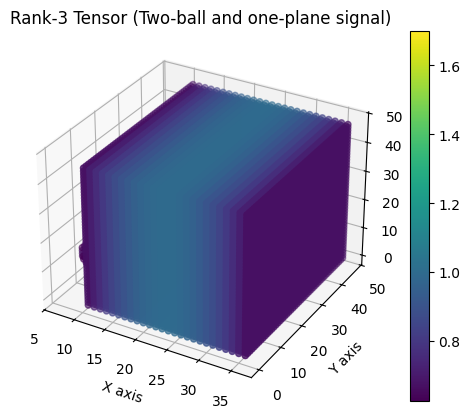

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Assume these are dimensions of the MRI data
dim_x1, dim_x2, dim_x3 = 48, 48, 48

# Define function to create signal tensor
def create_signal_tensor(rank):
    if rank == 1:
        # One-ball signal (rank-1 decomposition)
        B1 = np.zeros((dim_x1, 1))
        B2 = np.zeros((dim_x2, 1))
        B3 = np.zeros((dim_x3, 1))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
        return B1, B2, B3

    elif rank == 2:
        # Two-ball signal (rank-2 decomposition)
        B1 = np.zeros((dim_x1, 2))
        B2 = np.zeros((dim_x2, 2))
        B3 = np.zeros((dim_x3, 2))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            B1[15 + j, 1] = np.sin(j * np.pi / 14)
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        return B1, B2, B3

    elif rank == 3:
        # Two-ball and one-plane signal (rank-3 decomposition)
        B1 = np.zeros((dim_x1, 3))
        B2 = np.zeros((dim_x2, 3))
        B3 = np.zeros((dim_x3, 3))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)  # Ball 1
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            
            B1[15 + j, 1] = np.sin(j * np.pi / 14)  # Ball 2
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        
        # Plane-like signal
        B1[:, 2] = np.sin(np.linspace(0, np.pi, dim_x1))  # A plane signal along x1 axis
        B2[:, 2] = np.ones((dim_x2))  # Constant value in B2
        B3[:, 2] = np.ones((dim_x3))  # Constant value in B3
        return B1, B2, B3

# Function to pack the rank-3 tensor using np.tensordot
def pack_tensor(B1, B2, B3):
    tensor = np.zeros((dim_x1, dim_x2, dim_x3))
    for i in range(B1.shape[1]):  # Loop over components of the rank
        tensor += np.tensordot(np.tensordot(B1[:, i], B2[:, i], axes=0), B3[:, i], axes=0)
    return tensor

# Function to plot 3D tensor using scatter plot
def plot_3d_tensor_scatter(tensor, title="3D Tensor Scatter Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare the grid matching the tensor dimensions
    x, y, z = np.meshgrid(np.arange(tensor.shape[0]),
                          np.arange(tensor.shape[1]),
                          np.arange(tensor.shape[2]),
                          indexing='ij')

    # Smooth the tensor values for visualization
    tensor_smoothed = gaussian_filter(tensor, sigma=1)

    # Flatten the arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values = tensor_smoothed.flatten()

    # Select points where tensor values are significant (above a threshold)
    isovalue = tensor_smoothed.mean()
    mask = values > isovalue
    x_plot = x_flat[mask]
    y_plot = y_flat[mask]
    z_plot = z_flat[mask]
    values_plot = values[mask]

    # Plot the scatter
    scatter = ax.scatter(x_plot, y_plot, z_plot, c=values_plot, cmap='viridis', marker='o')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Add color bar to indicate values
    fig.colorbar(scatter, ax=ax)

    plt.show()

# Example usage:
# Generate and pack the rank-3 tensor (two-ball and one-plane signal)
B1_rank3, B2_rank3, B3_rank3 = create_signal_tensor(rank=3)
tensor_rank3 = pack_tensor(B1_rank3, B2_rank3, B3_rank3)

# Plot the rank-3 tensor using scatter plot
plot_3d_tensor_scatter(tensor_rank3, title="Rank-3 Tensor (Two-ball and one-plane signal)")


In [57]:
y_sim = response_sim(lmci_tensor)
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, y_sim, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5


X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.max
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.13453584459707738
CP train RSE:  1.1888564251697613e-06
Tucker train RSE:  1.6882569727303209e-06
mean test RSE:  0.29342652103579925
CP test RSE:  0.2692021282137888
Tucker test RSE:  0.2633725516884797


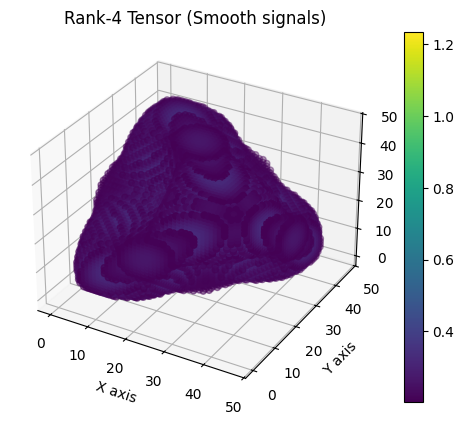

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Assume these are dimensions of the MRI data
dim_x1, dim_x2, dim_x3 = 48, 48, 48

# Define function to create signal tensor
def create_signal_tensor(rank):
    if rank == 1:
        # One-ball signal (rank-1 decomposition)
        B1 = np.zeros((dim_x1, 1))
        B2 = np.zeros((dim_x2, 1))
        B3 = np.zeros((dim_x3, 1))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
        return B1, B2, B3

    elif rank == 2:
        # Two-ball signal (rank-2 decomposition)
        B1 = np.zeros((dim_x1, 2))
        B2 = np.zeros((dim_x2, 2))
        B3 = np.zeros((dim_x3, 2))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            B1[15 + j, 1] = np.sin(j * np.pi / 14)
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        return B1, B2, B3

    elif rank == 3:
        # Two-ball and one-plane signal (rank-3 decomposition)
        B1 = np.zeros((dim_x1, 3))
        B2 = np.zeros((dim_x2, 3))
        B3 = np.zeros((dim_x3, 3))
        for j in range(8):
            B1[5 + j, 0] = np.sin(j * np.pi / 14)  # Ball 1
            B2[5 + j, 0] = np.sin(j * np.pi / 14)
            B3[5 + j, 0] = np.sin(j * np.pi / 14)
            
            B1[15 + j, 1] = np.sin(j * np.pi / 14)  # Ball 2
            B2[15 + j, 1] = np.sin(j * np.pi / 14)
            B3[15 + j, 1] = np.sin(j * np.pi / 14)
        
        # Plane-like signal
        B1[:, 2] = np.sin(np.linspace(0, np.pi, dim_x1))  # A plane signal along x1 axis
        B2[:, 2] = np.ones((dim_x2))  # Constant value in B2
        B3[:, 2] = np.ones((dim_x3))  # Constant value in B3
        return B1, B2, B3

    elif rank == 4:
        # Smooth signal (rank-4 decomposition) with Gaussian components
        B1 = np.zeros((dim_x1, 3))
        B2 = np.zeros((dim_x2, 3))
        B3 = np.zeros((dim_x3, 3))
        
        # Gaussian smooth signals along the x1, x2, and x3 axes
        B1[:, 0] = np.exp(-0.5 * (np.linspace(-2, 2, dim_x1) ** 2))  # Smooth Gaussian in x1
        B2[:, 0] = np.exp(-0.5 * (np.linspace(-2, 2, dim_x2) ** 2))  # Smooth Gaussian in x2
        B3[:, 0] = np.exp(-0.5 * (np.linspace(-2, 2, dim_x3) ** 2))  # Smooth Gaussian in x3
        
        # Adding another smooth sine signal component
        B1[:, 1] = np.sin(np.linspace(0, 2 * np.pi, dim_x1))
        B2[:, 1] = np.sin(np.linspace(0, 2 * np.pi, dim_x2))
        B3[:, 1] = np.sin(np.linspace(0, 2 * np.pi, dim_x3))
        
        # Final sine component for more variation
        B1[:, 2] = np.cos(np.linspace(0, 2 * np.pi, dim_x1)) * 0.5
        B2[:, 2] = np.cos(np.linspace(0, 2 * np.pi, dim_x2)) * 0.5
        B3[:, 2] = np.cos(np.linspace(0, 2 * np.pi, dim_x3)) * 0.5
        
        return B1, B2, B3

# Function to pack the tensor using np.tensordot
def pack_tensor(B1, B2, B3):
    tensor = np.zeros((dim_x1, dim_x2, dim_x3))
    for i in range(B1.shape[1]):  # Loop over components of the rank
        tensor += np.tensordot(np.tensordot(B1[:, i], B2[:, i], axes=0), B3[:, i], axes=0)
    return tensor

# Function to plot 3D tensor using scatter plot
def plot_3d_tensor_scatter(tensor, title="3D Tensor Scatter Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Prepare the grid matching the tensor dimensions
    x, y, z = np.meshgrid(np.arange(tensor.shape[0]),
                          np.arange(tensor.shape[1]),
                          np.arange(tensor.shape[2]),
                          indexing='ij')

    # Smooth the tensor values for visualization
    tensor_smoothed = gaussian_filter(tensor, sigma=1)

    # Flatten the arrays for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    values = tensor_smoothed.flatten()

    # Select points where tensor values are significant (above a threshold)
    isovalue = tensor_smoothed.mean()
    mask = values > isovalue
    x_plot = x_flat[mask]
    y_plot = y_flat[mask]
    z_plot = z_flat[mask]
    values_plot = values[mask]

    # Plot the scatter
    scatter = ax.scatter(x_plot, y_plot, z_plot, c=values_plot, cmap='viridis', marker='o')

    # Set labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title(title)

    # Add color bar to indicate values
    fig.colorbar(scatter, ax=ax)

    plt.show()

# Example usage:
# Generate and pack the rank-4 tensor (smooth signal)
B1_rank4, B2_rank4, B3_rank4 = create_signal_tensor(rank=4)
tensor_rank4 = pack_tensor(B1_rank4, B2_rank4, B3_rank4)

# Plot the rank-4 tensor using scatter plot
plot_3d_tensor_scatter(tensor_rank4, title="Rank-4 Tensor (Smooth signals)")


In [59]:
y_sim = response_sim(lmci_tensor)
X_train, X_test, y_train, y_test = train_test_split(lmci_tensor, y_sim, test_size=0.2, random_state=42)


print(X_train.shape,y_train.shape)
model  =  TensorDecisionTreeRegressor(max_depth=3, min_samples_split=12,split_method='variance_LS', split_rank=4, CP_reg_rank=12, Tucker_reg_rank=12, n_mode=3)
model.use_mean_as_threshold  =  False
model.sample_rate  =  .5


X_coarsen_shape = (1,4,4,4)
X_coarsen_func = np.max
X_train_c = block_reduce(X_train,block_size=X_coarsen_shape, func=X_coarsen_func)
X_test_c = block_reduce(X_test,block_size=X_coarsen_shape, func=X_coarsen_func)
#middle_z = X_train_c.shape[2] // 2
#X_train_c = X_train_c[:,:,:,middle_z:middle_z+2]
#X_test_c = X_test_c[:,:,:,middle_z:middle_z+2]
X_train_c = X_train_c+np.ones_like(X_train_c)*1e-3
print(X_train_c.shape,y_train.shape,X_test_c.shape)
model.fit(X_train_c,y_train)

predictions = model.predict(X_train_c,regression_method='mean')
print(f"mean train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='cp')
print(f"CP train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train))
predictions = model.predict(X_train_c,regression_method='tucker')
print(f"Tucker train RSE: ", np.mean((predictions-y_train)**2)/np.var(y_train)) 

predictions = model.predict(X_test_c,regression_method='mean')
print(f"mean test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='cp')
print(f"CP test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))
predictions = model.predict(X_test_c,regression_method='tucker')
print(f"Tucker test RSE: ", np.mean((predictions-y_test)**2)/np.var(y_test))

(320, 48, 48, 48) (320,)
(320, 12, 12, 12) (320,) (81, 12, 12, 12)
mean train RSE:  0.14494662801995795
CP train RSE:  1.2858105927672e-06
Tucker train RSE:  9.628271464171905e-07
mean test RSE:  0.3486591664893049
CP test RSE:  0.32817163175197356
Tucker test RSE:  0.42683377752850354
